In [1]:
import numpy as np
from neuralStellar import *
from datetime import datetime

Data headers = 
['', 'model_number', 'star_mass', 'star_age', 'star_feh', 'star_MLT', 'star_fov', 'effective_T', 'luminosity', 'radius', 'log_g', 'surface_h1', 'surface_he4', 'center_h1', 'center_he4', 'log_center_T', 'log_center_Rho', 'he_core_mass', 'delta_nu', 'delta_Pg', 'nu_max', 'nu_0_10', 'nu_0_11', 'nu_0_12', 'nu_0_13', 'nu_0_14', 'nu_0_15']


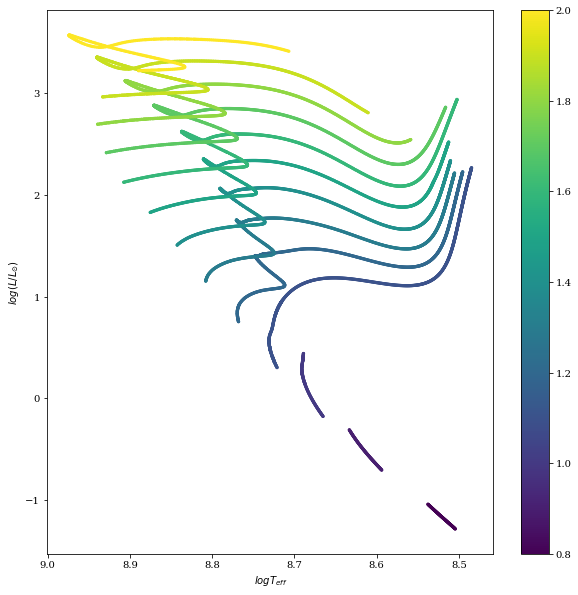

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 3,330
Trainable params: 3,330
Non-trainable params: 0
___________________________________________________________

In [2]:
file='grid_0_0.csv'
small_grid=neuralStellar(file)
small_grid.buildIndex()
small_grid.popIndex(['','star_mass','star_age','effective_T','luminosity'])
small_grid.initialData(age_range=[1,8])
small_grid.plotHR1('ranged')
#main code bit
x_in=small_grid.fetchData('evo',['mass','age'])
y_out=small_grid.fetchData('evo',['L','Teff'])
m1=NNModel('evo')
m1.buildModel(True, inout_shape=[len(x_in),len(y_out)],no_layers=4,no_nodes=32, reg=['l2',0.01])
#m1.buildModel(False, call_name='small_grid_model_test.h5')
m1.compileModel(0.0001,'MAE',metrics=['MAE','MSE'])

In [6]:
#temporary fitting code
epoch_no=100
class showProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % int(epoch_no/100) == 0:
            percent= int(np.round((epoch/int(epoch_no/100)),0))
            time=datetime.now()
            time_lapsed = (time-start_time)
            print(str(percent)+'% | epoch='+str(epoch)+'/'+str(epoch_no)+' | now='+str(time)[:-7]+
                  ' | time lapsed='+str(time_lapsed)[:-7]+' | loss='+str(np.round(logs['loss'],5)))
logdir = "logs\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir='logs'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
            
start_time=datetime.now()
m1.history=m1.model.fit(np.array(x_in).T,np.array(y_out).T,
                  epochs=epoch_no,
                  batch_size=len(x_in[0]),
                  validation_split=0.10,
                  verbose=0,
                  callbacks=[showProgress()])
print('training done! now='+str(datetime.now())+' | Time lapsed='+str(datetime.now()-start_time))
m1.model.save('small_grid_model_test.h5')

0% | epoch=0/100 | now=2019-11-20 16:24:06 | time lapsed=0:00:02 | loss=3.36455
1% | epoch=1/100 | now=2019-11-20 16:24:06 | time lapsed=0:00:02 | loss=3.3598
2% | epoch=2/100 | now=2019-11-20 16:24:06 | time lapsed=0:00:03 | loss=3.35599
3% | epoch=3/100 | now=2019-11-20 16:24:06 | time lapsed=0:00:03 | loss=3.35226
4% | epoch=4/100 | now=2019-11-20 16:24:07 | time lapsed=0:00:03 | loss=3.34844
5% | epoch=5/100 | now=2019-11-20 16:24:07 | time lapsed=0:00:03 | loss=3.34453
6% | epoch=6/100 | now=2019-11-20 16:24:07 | time lapsed=0:00:03 | loss=3.34055
7% | epoch=7/100 | now=2019-11-20 16:24:07 | time lapsed=0:00:03 | loss=3.33648
8% | epoch=8/100 | now=2019-11-20 16:24:07 | time lapsed=0:00:03 | loss=3.33233
9% | epoch=9/100 | now=2019-11-20 16:24:07 | time lapsed=0:00:03 | loss=3.3281
10% | epoch=10/100 | now=2019-11-20 16:24:07 | time lapsed=0:00:03 | loss=3.3238
11% | epoch=11/100 | now=2019-11-20 16:24:07 | time lapsed=0:00:03 | loss=3.31944
12% | epoch=12/100 | now=2019-11-20 16:

In [3]:
m1.fitModel(x_in, y_out, 10, len(x_in[0]),'small_grid_model_test.h5', keep_log=False)

training done! now=2019-11-20 16:54:12.961989 | Time lapsed=0:00:03.437582


final loss =2.3570416
1700/1 - 0s - loss: 3.2758 - MAE: 2.2867 - MSE: 7.0729
13600/1 - 0s


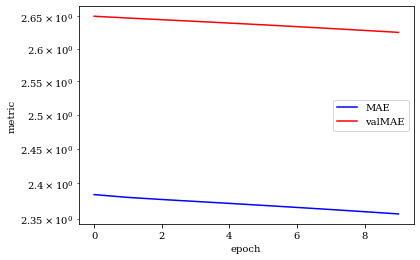

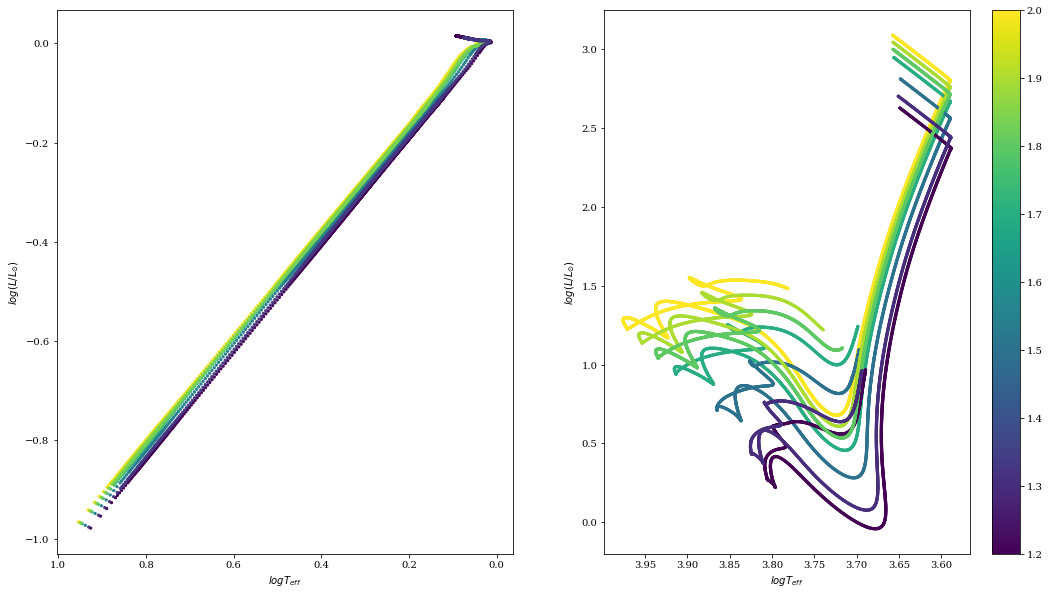

In [6]:
m1.plotHist(plot_MSE=False)
print('final loss ='+str(m1.lastLoss('MAE')))
m1.evalData(small_grid, 7)
m1.plotHR(small_grid, 8)